# Interpolate NSIDC SIC onto 1deg grid
See https://arccss.slack.com/archives/C08KM5KS6/p1619069437037300 and emails with Will Hobbs, 29-30 April 2021

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm_notebook
import pandas as pd
import xesmf

In [2]:
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:40971 Dashboard: /proxy/35703/status,Cluster Workers: 47 Cores: 47 Memory: 204.01 GB


In [3]:
def get_sic_obs(path, pattern, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the monthly nc files in obsFileList.
    '''
    dataarrays = []
    files = glob(os.path.join(path, pattern))
    for f in tqdm_notebook(files, leave=False, desc='loading files'):
        dataarrays.append(xr.open_dataset(f, decode_times=False)[variable])
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units })

    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1), np.nan)
    
    # use the same coord names as access-om2 t grid
    dataarray = dataarray.rename(({'xgrid': 'xt_ocean', 'ygrid': 'yt_ocean'}))
    
    # sort by time
    dataarray = dataarray.sortby('time')

    return dataarray

In [4]:
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202

obs_NH = get_sic_obs(ObsDir, 'north/monthly/*.nc')
obs_SH = get_sic_obs(ObsDir, 'south/monthly/*.nc')

loading files:   0%|          | 0/493 [00:00<?, ?it/s]

loading files:   0%|          | 0/493 [00:00<?, ?it/s]

In [5]:
def G02202_obs_regridder(grid_in, grid_out, method='bilinear', **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a NSIDC G02202 NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc           
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})         

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, reuse_weights=os.path.exists(weightfn), filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

In [6]:
obsfile_NH = ObsDir+'/north/monthly/seaice_conc_monthly_nh_f08_198708_v03r01.nc'
regrid_NHobs_to_1 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_10.nc')
# regrid_NHobs_to_025 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_025.nc')
# regrid_NHobs_to_01 = G02202_obs_regridder(obsfile_NH, '/g/data/ik11/grids/ocean_grid_01.nc')

obsfile_SH = ObsDir+'/south/monthly/seaice_conc_monthly_sh_f08_198708_v03r01.nc'
regrid_SHobs_to_1 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_10.nc')
# regrid_SHobs_to_025 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_025.nc')
# regrid_SHobs_to_01 = G02202_obs_regridder(obsfile_SH, '/g/data/ik11/grids/ocean_grid_01.nc')

In [7]:
regridded_NH = regrid_NHobs_to_1(obs_NH)
regridded_SH = regrid_SHobs_to_1(obs_SH)
regridded = regridded_NH.where(regridded_NH.yt_ocean > 0, other=regridded_SH)

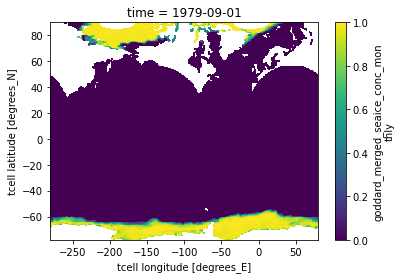

In [8]:
regridded.isel(time=10).plot()

In [10]:
for i, t in enumerate(regridded.time):
    fname = '_'.join(['G02202_V3_SIC_ACCESSOM2_1deg'] + str(t.data).split('-')[0:2])+'.nc'
    print(i, fname)
    regridded.isel(time=[i]).to_netcdf(path=fname, unlimited_dims='time')  # BUG: no time axis

0 G02202_V3_SIC_ACCESSOM2_1deg_1978_11.nc
1 G02202_V3_SIC_ACCESSOM2_1deg_1978_12.nc
2 G02202_V3_SIC_ACCESSOM2_1deg_1979_01.nc
3 G02202_V3_SIC_ACCESSOM2_1deg_1979_02.nc
4 G02202_V3_SIC_ACCESSOM2_1deg_1979_03.nc
5 G02202_V3_SIC_ACCESSOM2_1deg_1979_04.nc
6 G02202_V3_SIC_ACCESSOM2_1deg_1979_05.nc
7 G02202_V3_SIC_ACCESSOM2_1deg_1979_06.nc
8 G02202_V3_SIC_ACCESSOM2_1deg_1979_07.nc
9 G02202_V3_SIC_ACCESSOM2_1deg_1979_08.nc
10 G02202_V3_SIC_ACCESSOM2_1deg_1979_09.nc
11 G02202_V3_SIC_ACCESSOM2_1deg_1979_10.nc
12 G02202_V3_SIC_ACCESSOM2_1deg_1979_11.nc
13 G02202_V3_SIC_ACCESSOM2_1deg_1979_12.nc
14 G02202_V3_SIC_ACCESSOM2_1deg_1980_01.nc
15 G02202_V3_SIC_ACCESSOM2_1deg_1980_02.nc
16 G02202_V3_SIC_ACCESSOM2_1deg_1980_03.nc
17 G02202_V3_SIC_ACCESSOM2_1deg_1980_04.nc
18 G02202_V3_SIC_ACCESSOM2_1deg_1980_05.nc
19 G02202_V3_SIC_ACCESSOM2_1deg_1980_06.nc
20 G02202_V3_SIC_ACCESSOM2_1deg_1980_07.nc
21 G02202_V3_SIC_ACCESSOM2_1deg_1980_08.nc
22 G02202_V3_SIC_ACCESSOM2_1deg_1980_09.nc
23 G02202_V3_SIC_ACCE